In [455]:
%load_ext autoreload
%autoreload 2
%load_ext autotime

import os
import random

import numpy as np
import pandas as pd
import torch
from matplotlib import pyplot as plt

%matplotlib inline
plt.rcParams["figure.figsize"] = [9, 2]
plt.rcParams["figure.dpi"] = 200
plt.rcParams["agg.path.chunksize"] = 100000
pd.set_option("plotting.backend", "matplotlib")
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
The autotime extension is already loaded. To reload it, use:
  %reload_ext autotime


time: 2.93 ms (started: 2023-04-26 11:35:34 -07:00)


In [456]:
from pprint import pprint
from numalogic.config import ModelInfo
from omegaconf import OmegaConf
from numalogic.models.autoencoder import AutoencoderTrainer
from numalogic.preprocess import TanhScaler
from benchmarks.kpi.datamodule import KPIDataModule

# KPI index to use
KPI_ID = 14

# Path variables
DATA_FILE_PATH = "data/Finals_dataset/phase2_train.csv"
MODEL_PATH = f"results/kpi_idx_{KPI_ID}/"
MODEL_NAME = "conv"

# Load hyperparams file
hyperparams = OmegaConf.load(os.path.join(MODEL_PATH, MODEL_NAME, "hyperparams.json"))
model_schema = OmegaConf.structured(ModelInfo)
model_conf = OmegaConf.merge(model_schema, hyperparams["MODEL"])
pprint(dict(hyperparams), indent=2)

{ 'BATCH_SIZE': 64,
  'MODEL': {'name': 'Conv1dAE', 'conf': {'seq_len': 16, 'in_channels': 1, 'enc_channels': [4, 8, 16, 2], 'weight_decay': 0.0001}},
  'SPLIT_RATIOS': [0.5, 0.2, 0.3],
  'TRAINER': {'accelerator': 'cpu', 'max_epochs': 30}}
time: 4.08 ms (started: 2023-04-26 11:35:43 -07:00)


In [457]:
from numalogic.config.factory import ModelFactory

datamodule = KPIDataModule(
    DATA_FILE_PATH,
    KPI_ID,
    [TanhScaler()],
    split_ratios=hyperparams["SPLIT_RATIOS"],
    seq_len=model_conf.conf.seq_len,
    batch_size=hyperparams["BATCH_SIZE"],
)
model = ModelFactory().get_instance(model_info=model_conf)

trainer = AutoencoderTrainer(
    **hyperparams["TRAINER"],
    enable_progress_bar=True,
    enable_model_summary=True,
    num_sanity_val_steps=0
)
trainer.fit(model, datamodule=datamodule)

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


time: 1.59 s (started: 2023-04-26 11:35:53 -07:00)


In [458]:
# Uncomment the following lines for loading a saved model
# model_cls = ModelFactory().get_cls(model_info=model_conf)
# model = model_cls.load_from_checkpoint(os.path.join(MODEL_PATH, MODEL_NAME, "model2.pth"), **model_conf.conf)
# model.eval()
# datamodule.setup("fit")
# datamodule.setup("predict")

Train size: (64524, 1)
Val size: (12904, 1)
Test size: (38713, 1)
time: 14.3 ms (started: 2023-04-26 11:36:03 -07:00)


In [459]:
train_reconerr = trainer.predict(model, dataloaders=datamodule.train_dataloader(), unbatch=True).numpy()
val_reconerr = trainer.predict(model, dataloaders=datamodule.val_dataloader(), unbatch=True).numpy()

time: 2.18 s (started: 2023-04-26 11:36:04 -07:00)


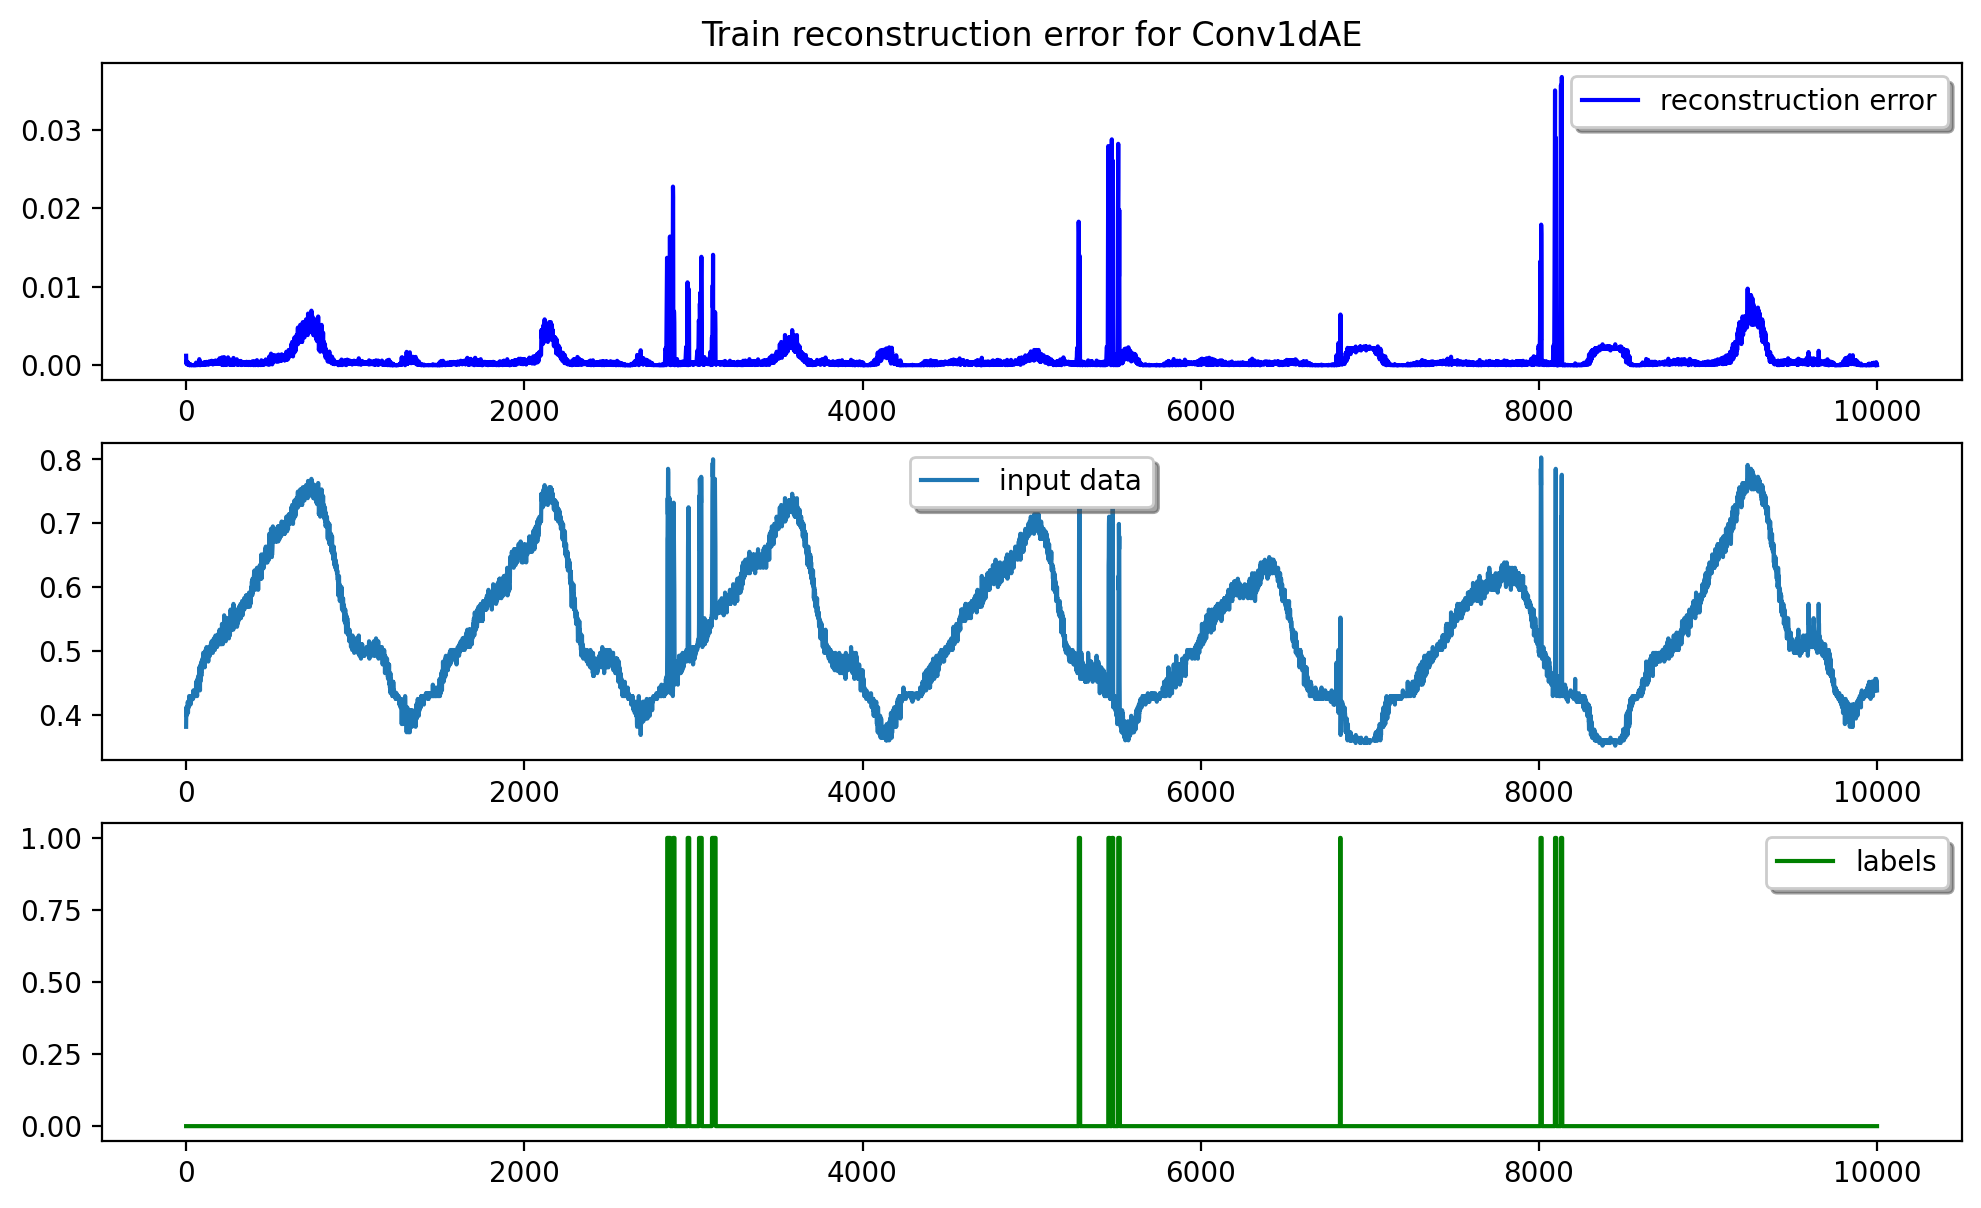

time: 649 ms (started: 2023-04-26 11:36:08 -07:00)


In [460]:
from benchmarks.plots import plot_reconerr_comparision

fig = plot_reconerr_comparision(train_reconerr, datamodule.train_data, datamodule.train_labels, end=10000, title=f"Train reconstruction error for {model_conf.name}")
fig.savefig(os.path.join(MODEL_PATH, MODEL_NAME, "train.png"))

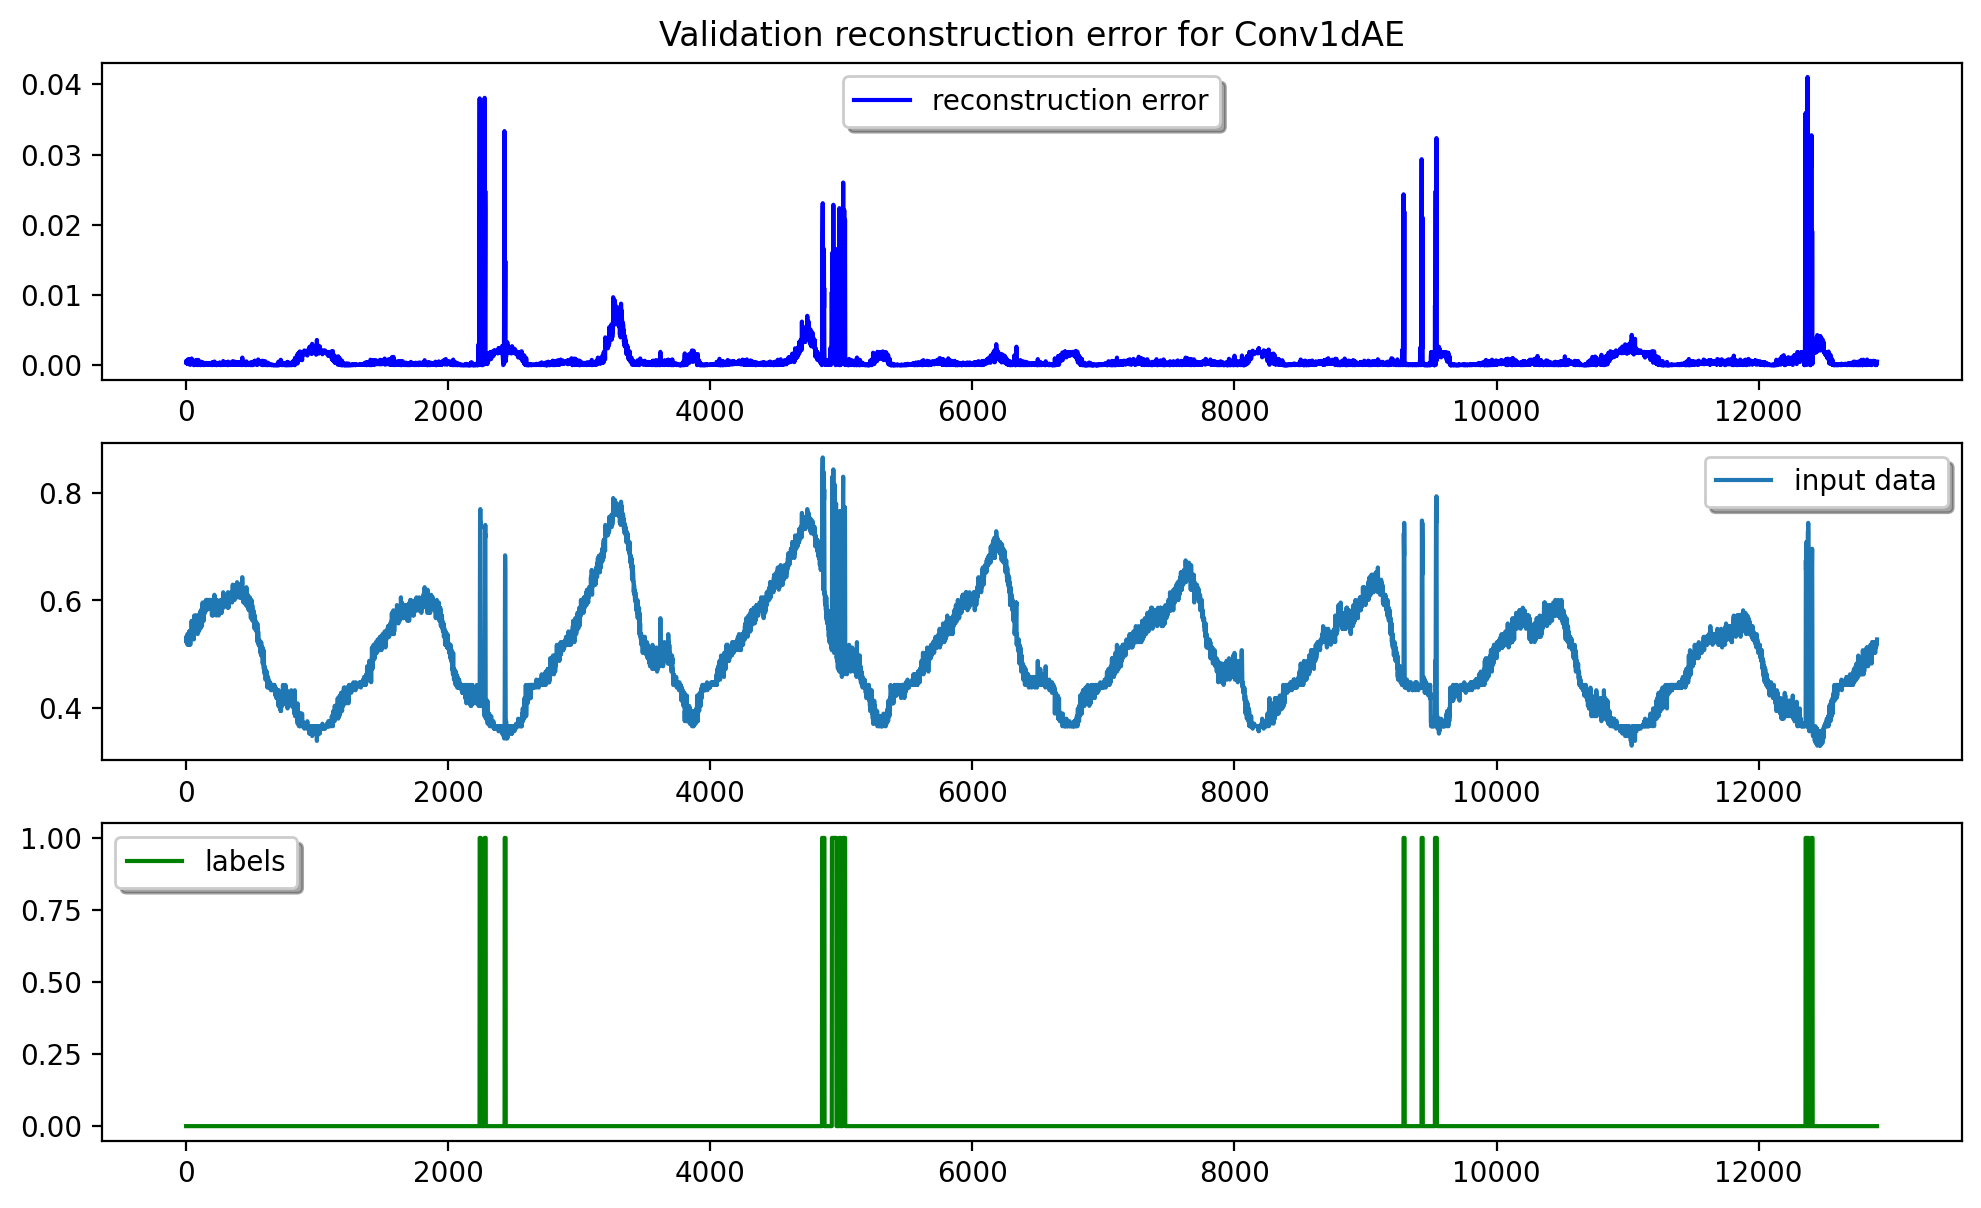

time: 648 ms (started: 2023-04-26 11:36:17 -07:00)


In [461]:
fig = plot_reconerr_comparision(val_reconerr, datamodule.val_data, datamodule.val_labels, title=f"Validation reconstruction error for {model_conf.name}")
fig.savefig(os.path.join(MODEL_PATH, MODEL_NAME, "val.png"))

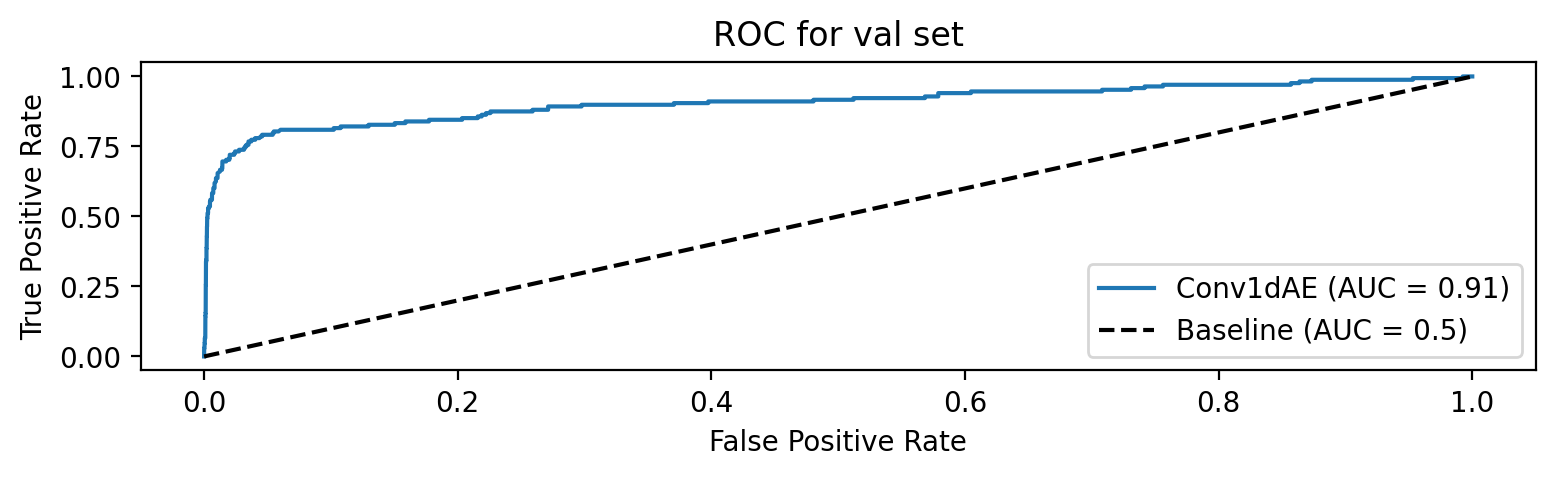

time: 219 ms (started: 2023-04-26 11:36:20 -07:00)


In [462]:
from benchmarks.plots import plot_roc_curve

plot_roc_curve(datamodule.val_labels, val_reconerr, model_conf.name, title="ROC for val set")
plt.savefig(os.path.join(MODEL_PATH, MODEL_NAME, "roc_val.png"), bbox_inches='tight')

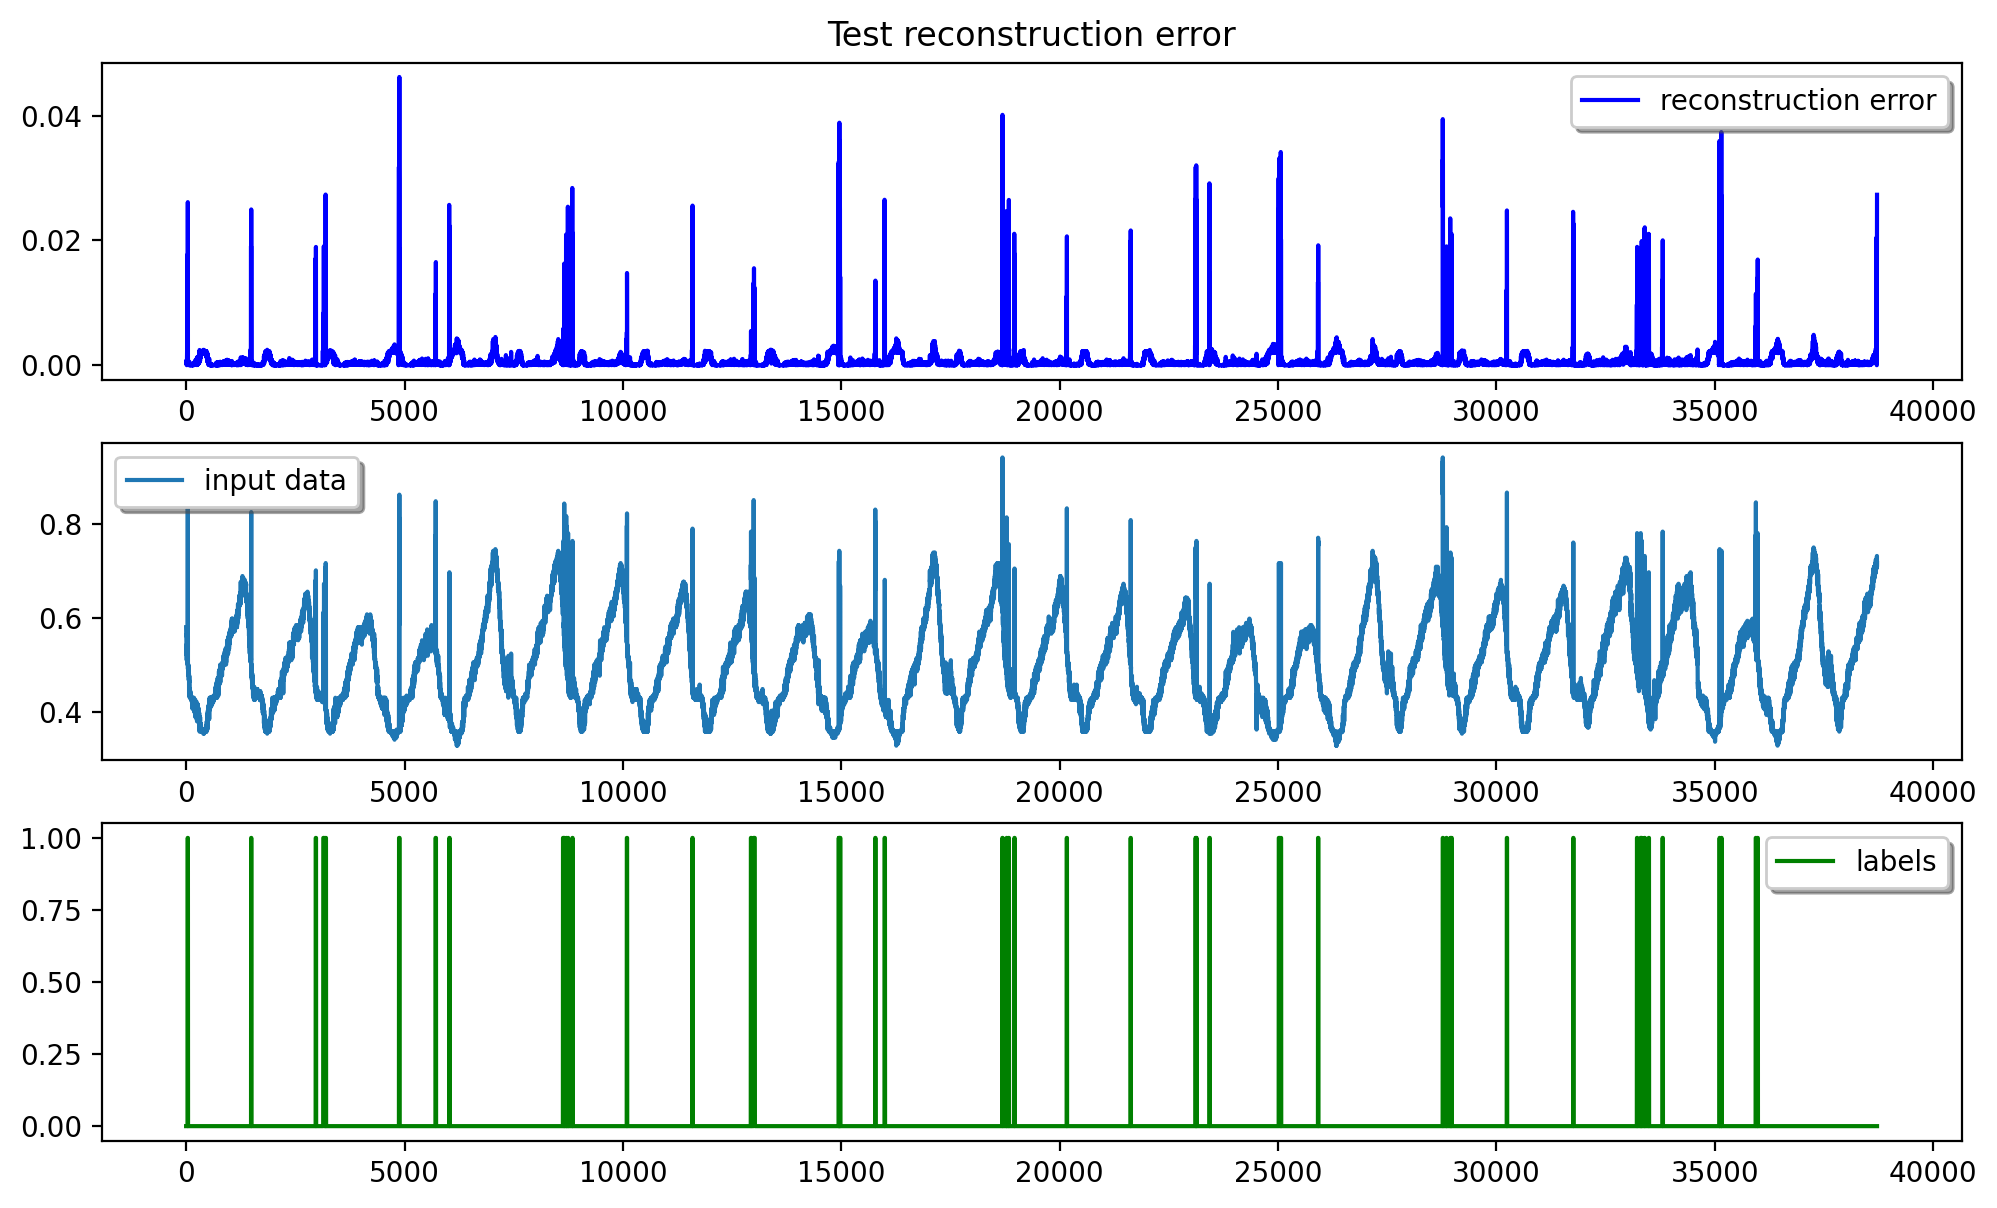

time: 2.06 s (started: 2023-04-26 11:36:22 -07:00)


In [463]:
test_reconerr = trainer.predict(model, dataloaders=datamodule.predict_dataloader()).numpy()
fig = plot_reconerr_comparision(test_reconerr, datamodule.test_data, datamodule.test_labels, title="Test reconstruction error")
fig.savefig(os.path.join(MODEL_PATH, MODEL_NAME, "test.png"))

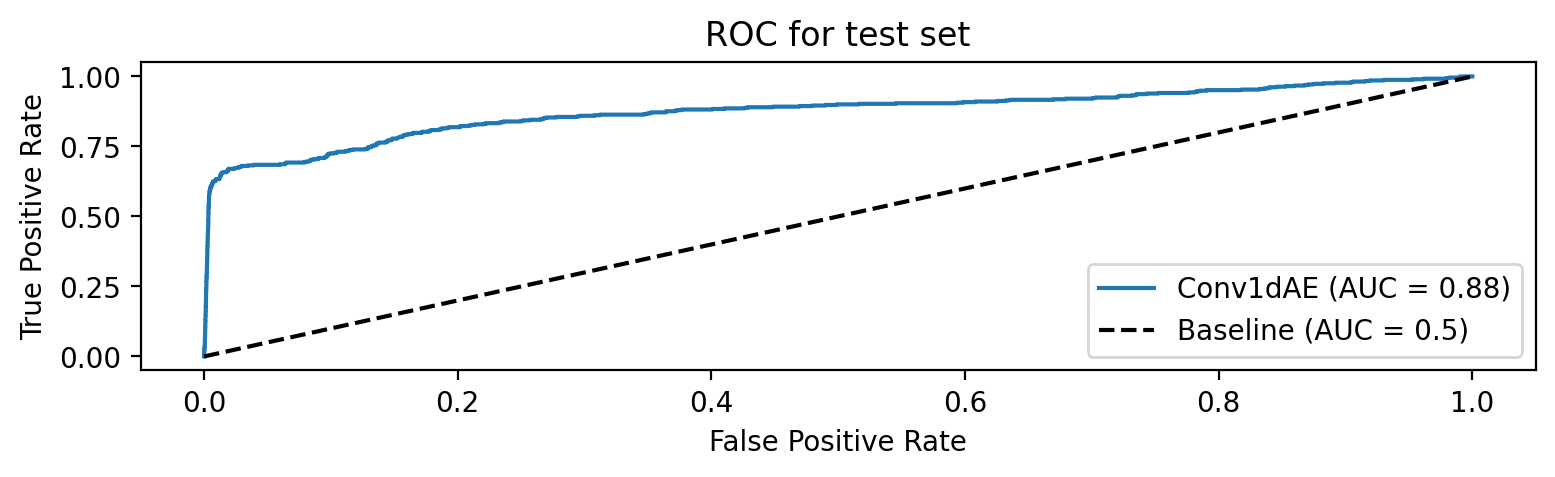

time: 225 ms (started: 2023-04-26 11:36:24 -07:00)


In [464]:
plot_roc_curve(datamodule.test_labels, test_reconerr, model_conf.name, title="ROC for test set")
plt.savefig(os.path.join(MODEL_PATH, MODEL_NAME, "roc_test.png"), bbox_inches='tight')

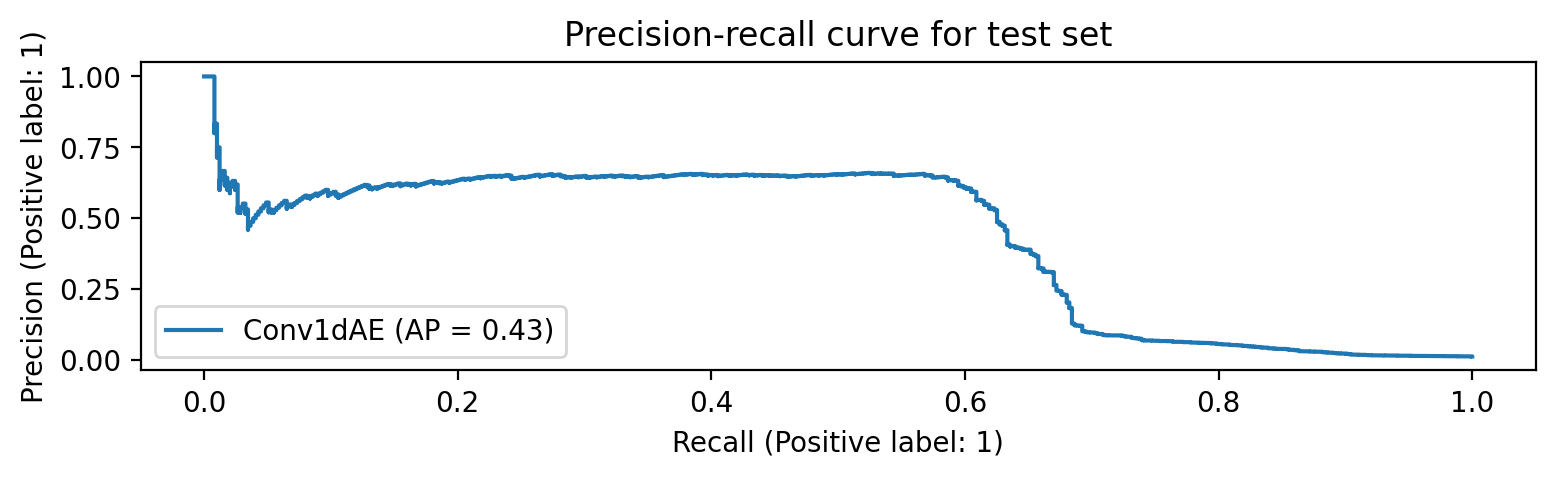

time: 191 ms (started: 2023-04-26 11:36:27 -07:00)


In [465]:
from sklearn.metrics import PrecisionRecallDisplay

PrecisionRecallDisplay.from_predictions(datamodule.test_labels, test_reconerr, name=model_conf.name)
plt.title(f"Precision-recall curve for test set")
plt.savefig(os.path.join(MODEL_PATH, MODEL_NAME, "pr_curve_test.png"))

In [251]:
# Uncomment this to save the model
# trainer.save_checkpoint(os.path.join(MODEL_PATH, MODEL_NAME, "model.pth"))
# print(hyperparams)

{'BATCH_SIZE': 64, 'SPLIT_RATIOS': [0.5, 0.2, 0.3], 'TRAINER': {'accelerator': 'cpu', 'max_epochs': 30}, 'MODEL': {'name': 'Conv1dAE', 'conf': {'seq_len': 16, 'in_channels': 1, 'enc_channels': [4, 8, 16, 2], 'weight_decay': 0.0001}}}
time: 4.45 ms (started: 2023-04-25 20:19:29 -07:00)
